In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset

df = pd.read_csv('Phishing_Email.csv')

In [4]:
# Drop unnecessary columns and rename for clarity

df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.rename(columns={'Email Text': 'email_text', 'Email Type': 'label'})

In [5]:
# Handle missing values

df['email_text'] = df['email_text'].astype(str)
df['email_text'] = df['email_text'].fillna('')

df['label'] = df['label'].map({'Safe Email': 0, 'Phishing Email': 1})

In [6]:
# Data exploration

print("Dataset shape:", df.shape)
print("Label distribution:")
print(df['label'].value_counts())

Dataset shape: (18650, 2)
Label distribution:
0    11322
1     7328
Name: label, dtype: int64


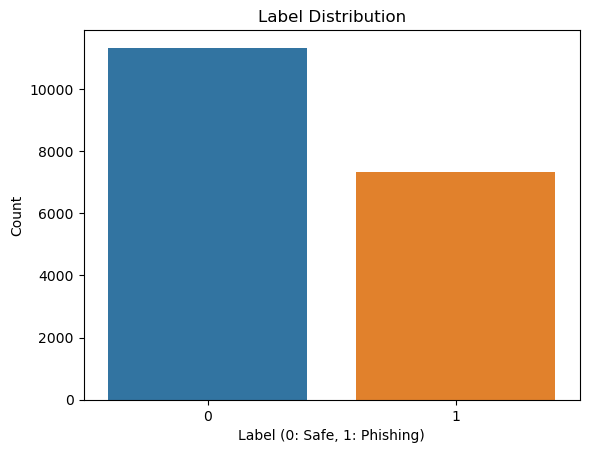

In [7]:
# Visualization of label distribution

sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label (0: Safe, 1: Phishing)')
plt.ylabel('Count')
plt.show()

In [8]:
# Preprocessing function

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [9]:
# Apply preprocessing

df['cleaned_text'] = df['email_text'].apply(clean_text)

In [10]:
# Train-test split

X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# TF-IDF Vectorization

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
# Model training

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Model evaluation

y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9621983914209116
Confusion Matrix:
[[2194   79]
 [  62 1395]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2273
           1       0.95      0.96      0.95      1457

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



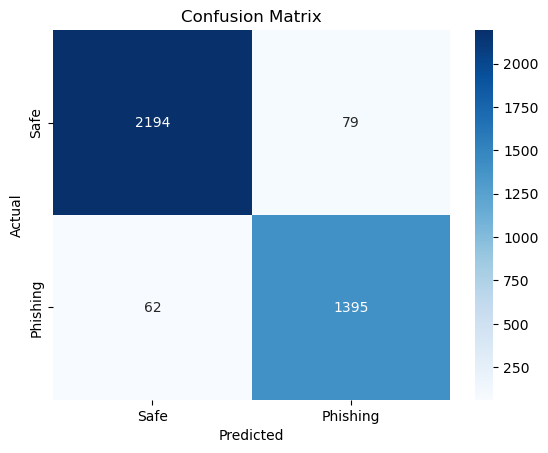

In [14]:
# Confusion matrix visualization

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure the 'models' directory exists
if not os.path.exists("models"):
    os.makedirs("models")

# Define sample training data (replace with actual training dataset)
X_train = ["This is a safe email", "Urgent! Your account has been compromised"]
y_train = [0, 1]  # 0 = Safe, 1 = Phishing

# Initialize TF-IDF Vectorizer (if not previously defined)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)

# Save the trained vectorizer
with open("models/tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Vectorizer saved successfully!")


Vectorizer saved successfully!


In [22]:
import pickle
import os

# Define paths
MODEL_PATH = "models/phishing_model.pkl"
VECTORIZER_PATH = "models/tfidf_vectorizer.pkl"

# Initialize model and vectorizer as None
model, vectorizer = None, None

def load_model_and_vectorizer():
    """Loads the trained phishing detection model and TF-IDF vectorizer."""
    global model, vectorizer

    if not os.path.exists(MODEL_PATH):
        print(f" Error: Model file '{MODEL_PATH}' not found.")
        return
    
    if not os.path.exists(VECTORIZER_PATH):
        print(f" Error: Vectorizer file '{VECTORIZER_PATH}' not found.")
        return

    try:
        with open(MODEL_PATH, "rb") as model_file:
            model = pickle.load(model_file)
        print(" Model loaded successfully.")

        with open(VECTORIZER_PATH, "rb") as vectorizer_file:
            vectorizer = pickle.load(vectorizer_file)
        print(" Vectorizer loaded successfully.")

    except Exception as e:
        print(f" Error loading model/vectorizer: {e}")

# Call the function to load them
load_model_and_vectorizer()

# Ensure model is loaded before making predictions
if model and vectorizer:
    def predict_email(email_content):
        """Predicts if an email is phishing or legitimate."""
        try:
            transformed_content = vectorizer.transform([email_content])
            prediction = model.predict(transformed_content)[0]
            return "Phishing" if prediction == 1 else "Legitimate"
        except Exception as e:
            return f" Prediction error: {e}"

    # Test the function
    sample_email = "You have won a free iPhone! Click the link to claim your prize."
    print("Prediction:", predict_email(sample_email))
else:
    print("Model and vectorizer not loaded. Prediction cannot be performed.")


 Model loaded successfully.
 Vectorizer loaded successfully.
Prediction:  Prediction error: X has 10 features, but RandomForestClassifier is expecting 5000 features as input.


In [24]:
from googleapiclient.discovery import build
from google.oauth2.credentials import Credentials

def fetch_emails():
    """Fetch emails from Gmail."""
    creds = Credentials.from_authorized_user_file('credentials.json', ['https://www.googleapis.com/auth/gmail.readonly'])
    service = build('gmail', 'v1', credentials=creds)

    # Fetch emails
    results = service.users().messages().list(userId='me', labelIds=['INBOX'], maxResults=10).execute()
    messages = results.get('messages', [])
    for message in messages:
        msg = service.users().messages().get(userId='me', id=message['id']).execute()
        email_content = msg.get('snippet', '')
        prediction = predict_email(email_content)
        print(f"Email: {email_content}\nPrediction: {prediction}\n")

In [26]:
# %%writefile app/train_model.py

In [28]:
# Dockerfile content
dockerfile_content = """
# Base image
FROM python:3.9-slim

# Set the working directory
WORKDIR /app

# Copy the app files
COPY . /app

# Install dependencies
RUN pip install -r requirements.txt

# Expose the app port
EXPOSE 5000

# Run the app
CMD ["python", "app.py"]
"""

# Write the Dockerfile to the current directory
with open("Dockerfile", "w") as dockerfile:
    dockerfile.write(dockerfile_content)

print("Dockerfile created successfully!")

Dockerfile created successfully!
